In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from  tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.layers import Attention
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [ ]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((196, 196))
image_size = 0
directory_root = '/content/drive/MyDrive/PLANT_DISEASES_DATASET/RESIZE'
width=196
height=196
depth=3

In [ ]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:

            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
            print(f"[INFO] Processing {plant_disease_folder} {len(plant_disease_image_list)}")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or image_directory.endswith(".JPEG") == True:
                    image = cv2.imread(image_directory)
                    if image is not None :
                        image = cv2.resize(image, (196, 196)).flatten()
                        image_list.append(image)
                        label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing APPLE_HEALTHY 1500
[INFO] Processing APPLE_RUST 1500
[INFO] Processing APPLE_SCAB 1500
[INFO] Processing CASHEW_ANTHRACNOSE 1500
[INFO] Processing CASHEW_HEALTHY 1500
[INFO] Processing CASHEW_RED_RUST 1500
[INFO] Processing CASSAVA_BROWN_SPOT 1500
[INFO] Processing CASSAVA_HEALTHY 1500
[INFO] Processing CASSAVA_MOSAIC_VIRUS 1500
[INFO] Processing COCOA_ANTHRACNOSE 1500
[INFO] Processing COCOA_CSSVD 1500
[INFO] Processing COCOA_HEALTHY 1500
[INFO] Processing GRAPE_BLACK_MEASLES 1500
[INFO] Processing GRAPE_BLACK_ROT 1500
[INFO] Processing GRAPE_HEALTHY 1500
[INFO] Processing GROUNDNUT_HEALTHY 1500
[INFO] Processing GROUNDNUT_LEAF_SPOT 1500
[INFO] Processing GROUNDNUT_RUST 1500
[INFO] Processing MAIZE_HEALTHY 1500
[INFO] Processing MAIZE_MOSAIC_VIRUS 1500
[INFO] Processing MAIZE_STREAK_VIRUS 1500
[INFO] Processing POTATO_EARLY_BLIGHT 1500
[INFO] Processing POTATO_HEALTHY 1500
[INFO] Processing POTATO_LATE_BLIGHT 1500
[INFO] Processing TOMATO_EA

In [ ]:
image_size = len(image_list)

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['APPLE_HEALTHY' 'APPLE_RUST' 'APPLE_SCAB' 'BEANS_ANGULAR_LEAF_SPOT'
 'BEANS_HEALTHY' 'BEANS_RUST' 'CASHEW_ANTHRACNOSE' 'CASHEW_HEALTHY'
 'CASHEW_RED_RUST' 'CASSAVA_BROWN_SPOT' 'CASSAVA_HEALTHY'
 'CASSAVA_MOSAIC_VIRUS' 'COCOA_ANTHRACNOSE' 'COCOA_CSSVD' 'COCOA_HEALTHY'
 'GRAPE_BLACK_MEASLES' 'GRAPE_BLACK_ROT' 'GRAPE_HEALTHY'
 'GROUNDNUT_HEALTHY' 'GROUNDNUT_LEAF_SPOT' 'GROUNDNUT_RUST'
 'MAIZE_HEALTHY' 'MAIZE_MOSAIC_VIRUS' 'MAIZE_STREAK_VIRUS'
 'POTATO_EARLY_BLIGHT' 'POTATO_HEALTHY' 'POTATO_LATE_BLIGHT'
 'TOMATO_EARLY_BLIGHT' 'TOMATO_HEALTHY' 'TOMATO_SEPTORIA_LEAF_SPOT']


In [ ]:
np_image_list = np.array(image_list, dtype="float") / 255.0

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [ ]:
x_train_reshaped = x_train.reshape((-1,196, 196, 3))
x_test_reshaped = x_test.reshape((-1,196, 196, 3))

In [ ]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid

def attach_attention_module(net, attention_module):
  return cbam_block(net)

def cbam_block(cbam_feature, ratio=8):
	"""Contains the implementation of Convolutional Block Attention Module(CBAM) block.
	As described in https://arxiv.org/abs/1807.06521.
	"""

	cbam_feature = channel_attention(cbam_feature, ratio)
	cbam_feature = spatial_attention(cbam_feature)
	return cbam_feature

def channel_attention(input_feature, ratio=8):

	channel_axis = 1 if K.image_data_format() == "channels_first" else -1
	channel = input_feature.shape[channel_axis]

	shared_layer_one = Dense(channel//ratio,
							 activation='relu',
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')
	shared_layer_two = Dense(channel,
							 kernel_initializer='he_normal',
							 use_bias=True,
							 bias_initializer='zeros')

	avg_pool = GlobalAveragePooling2D()(input_feature)
	avg_pool = Reshape((1,1,channel))(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)
	avg_pool = shared_layer_one(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel//ratio)
	avg_pool = shared_layer_two(avg_pool)
	assert avg_pool.shape[1:] == (1,1,channel)

	max_pool = GlobalMaxPooling2D()(input_feature)
	max_pool = Reshape((1,1,channel))(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)
	max_pool = shared_layer_one(max_pool)
	assert max_pool.shape[1:] == (1,1,channel//ratio)
	max_pool = shared_layer_two(max_pool)
	assert max_pool.shape[1:] == (1,1,channel)

	cbam_feature = Add()([avg_pool,max_pool])
	cbam_feature = Activation('sigmoid')(cbam_feature)

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
	kernel_size = 7

	if K.image_data_format() == "channels_first":
		channel = input_feature.shape[1]
		cbam_feature = Permute((2,3,1))(input_feature)
	else:
		channel = input_feature.shape[-1]
		cbam_feature = input_feature

	avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
	assert avg_pool.shape[-1] == 1
	max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
	assert max_pool.shape[-1] == 1
	concat = Concatenate(axis=3)([avg_pool, max_pool])
	assert concat.shape[-1] == 2
	cbam_feature = Conv2D(filters = 1,
					kernel_size=kernel_size,
					strides=1,
					padding='same',
					activation='sigmoid',
					kernel_initializer='he_normal',
					use_bias=False)(concat)
	assert cbam_feature.shape[-1] == 1

	if K.image_data_format() == "channels_first":
		cbam_feature = Permute((3, 1, 2))(cbam_feature)

	return multiply([input_feature, cbam_feature])



In [ ]:
"""
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
"""
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

def cnn_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def cnn_v1(input_shape, depth, num_classes=n_classes, attention_module=None):
    """
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = cnn_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = cnn_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = cnn_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = cnn_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            # attention_module
            if attention_module is not None:
                y = attach_attention_module(y, attention_module)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:


from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np

# Training parameters
batch_size = 32
epochs = 25
data_augmentation = False
subtract_pixel_mean = True  # Subtracting pixel mean improves accuracy
# Choose what attention_module to use: cbam_block / se_block / None
attention_module = 'cbam_block'


# Input image dimensions.
input_shape = x_train_reshaped.shape[1:]


print('x_train shape:', x_train_reshaped.shape)
print(x_train_reshaped.shape[0], 'train samples')
print(x_test_reshaped.shape[0], 'test samples')
print('y_train shape:', y_train.shape)


depth = 50
model = cnn_v1(input_shape=input_shape, depth=depth, attention_module="cbam_block")

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.1),
              metrics=["accuracy"])
model.summary()

x_train shape: (4800, 196, 196, 3)
4800 train samples
1200 test samples
y_train shape: (4800, 30)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 196, 196, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 196, 196, 16)         448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 196, 196, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 196, 196, 16)         0         ['batch_normalization[0][0

In [ ]:
H = model.fit(x_train_reshaped, y_train, validation_data=(x_test_reshaped, y_test), epochs=25, batch_size=32)

Epoch 1/25
150/150 [==============================] - 43s 289ms/step - loss: 1.0908 - accuracy: 0.7715 - val_loss: 1.6823 - val_accuracy: 0.6092
Epoch 2/25
150/150 [==============================] - 38s 252ms/step - loss: 0.9034 - accuracy: 0.8102 - val_loss: 0.9959 - val_accuracy: 0.7717
Epoch 3/25
150/150 [==============================] - 38s 253ms/step - loss: 0.7679 - accuracy: 0.8585 - val_loss: 1.0632 - val_accuracy: 0.7658
Epoch 4/25
150/150 [==============================] - 38s 252ms/step - loss: 0.6847 - accuracy: 0.8840 - val_loss: 0.9274 - val_accuracy: 0.8083
Epoch 5/25
150/150 [==============================] - 38s 252ms/step - loss: 0.5710 - accuracy: 0.9112 - val_loss: 0.7844 - val_accuracy: 0.8550
Epoch 6/25
150/150 [==============================] - 38s 252ms/step - loss: 0.5306 - accuracy: 0.9254 - val_loss: 1.0451 - val_accuracy: 0.7750
Epoch 7/25
150/150 [==============================] - 38s 253ms/step - loss: 0.5120 - accuracy: 0.9279 - val_loss: 0.5709 - val_ac

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test_reshaped, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
38/38 [==============================] - 3s 80ms/step - loss: 0.4580 - accuracy: 0.9267
Test Accuracy: 92.66666769981384


38/38 [==============================] - 3s 80ms/step
Accuracy   : 0.9266666666666666
Precision : 0.9266666666666666
Recall    : 0.9266666666666666
F1-score  : 0.927030549048294


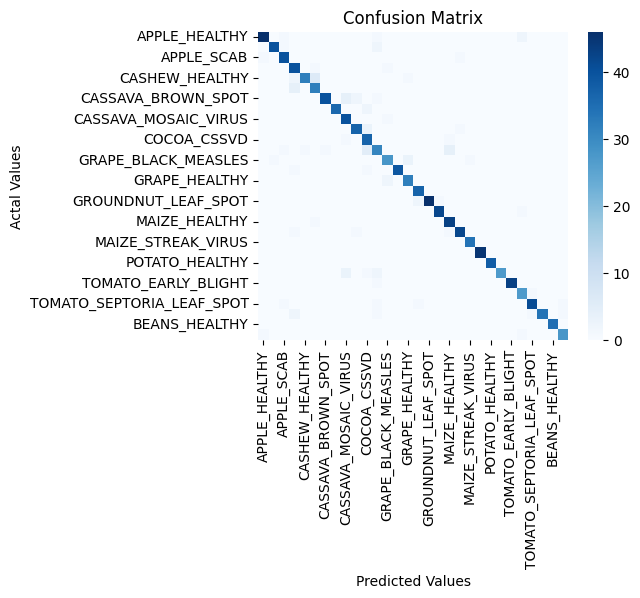

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, accuracy_score

y_pred = model.predict(x_test_reshaped)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy   :", accuracy)
precision = precision_score(y_test, y_pred, average='micro')
print("Precision :", precision)
recall = recall_score(y_test, y_pred, average='micro')
print("Recall    :", recall)
F1_score = f1_score(y_test, y_pred, average='weighted')
print("F1-score  :", F1_score)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['APPLE_HEALTHY','APPLE_RUST','APPLE_SCAB','CASHEW_ANTHRACNOSE','CASHEW_HEALTHY','CASHEW_RED_RUST','CASSAVA_BROWN_SPOT','CASSAVA_HEALTHY','CASSAVA_MOSAIC_VIRUS','COCOA_ANTHRACNOSE','COCOA_CSSVD','COCOA_HEALTHY','GRAPE_BLACK_MEASLES','GRAPE_BLACK_ROT','GRAPE_HEALTHY','GROUNDNUT_HEALTHY','GROUNDNUT_LEAF_SPOT','GROUNDNUT_RUST','MAIZE_HEALTHY','MAIZE_MOSAIC_VIRUS','MAIZE_STREAK_VIRUS','POTATO_EARLY_BLIGHT','POTATO_HEALTHY','POTATO_LATE_BLIGHT','TOMATO_EARLY_BLIGHT','TOMATO_HEALTHY','TOMATO_SEPTORIA_LEAF_SPOT','BEANS_ANGULAR_LEAF_SPOT','BEANS_HEALTHY','BEANS_RUST'],
                     columns = ['APPLE_HEALTHY','APPLE_RUST','APPLE_SCAB','CASHEW_ANTHRACNOSE','CASHEW_HEALTHY','CASHEW_RED_RUST','CASSAVA_BROWN_SPOT','CASSAVA_HEALTHY','CASSAVA_MOSAIC_VIRUS','COCOA_ANTHRACNOSE','COCOA_CSSVD','COCOA_HEALTHY','GRAPE_BLACK_MEASLES','GRAPE_BLACK_ROT','GRAPE_HEALTHY','GROUNDNUT_HEALTHY','GROUNDNUT_LEAF_SPOT','GROUNDNUT_RUST','MAIZE_HEALTHY','MAIZE_MOSAIC_VIRUS','MAIZE_STREAK_VIRUS','POTATO_EARLY_BLIGHT','POTATO_HEALTHY','POTATO_LATE_BLIGHT','TOMATO_EARLY_BLIGHT','TOMATO_HEALTHY','TOMATO_SEPTORIA_LEAF_SPOT','BEANS_ANGULAR_LEAF_SPOT','BEANS_HEALTHY','BEANS_RUST'])


plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()



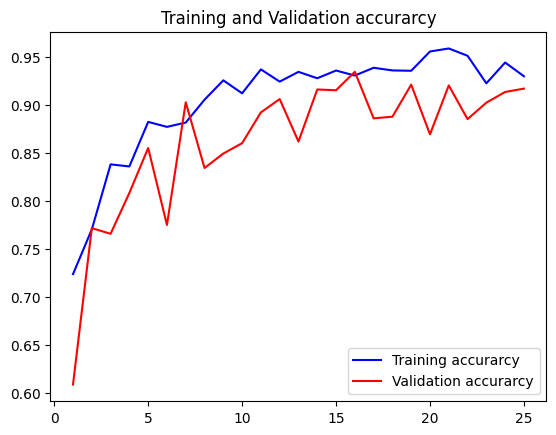

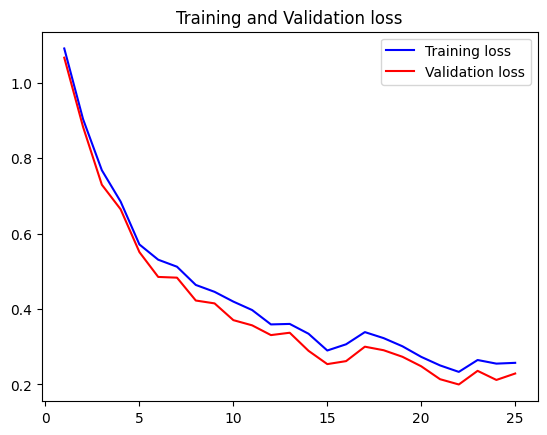

In [ ]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()